In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import pywt

from sleep_data import SleepDataMASS

/home/ntapia/miniconda3/envs/idp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



Loading MASS from checkpoint

Pages in train set: 5838
Pages in val set: 1952
Pages in test set: 3011

Pages in MASS dataset: 10801


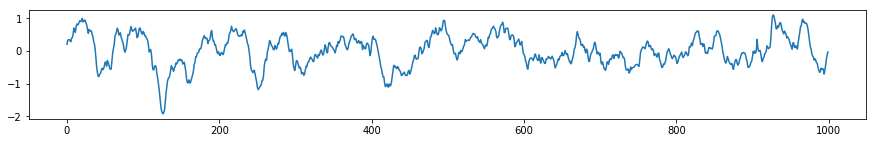

In [2]:
# simple signal segment
dataset = SleepDataMASS(load_from_checkpoint=True)
data_list = dataset.get_subset("val")
signal = data_list[0]["signal"]
pages = data_list[0]["pages"]

# Select page
page_idx = 0

start_sample = pages[page_idx]*20*200
end_sample = start_sample + 1000

segment = signal[start_sample:end_sample]

# Show signal
plt.figure(figsize=(15,2))
plt.plot(segment)
plt.show()

In [8]:
np.savetxt('demo_signal.csv', segment, delimiter=' ')

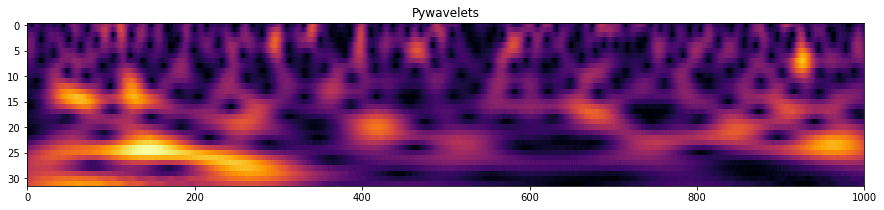

In [3]:
# Parameters CWT
fs = 200
fb_array = np.array([2])
lower_freq = 3
upper_freq = 40
n_scales = 32

# Generate initial and last scale
s_0 = fs / upper_freq
s_n = fs / lower_freq

# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))

# Pywavelets
w = pywt.ContinuousWavelet('cmor')
w.center_frequency = 1
w.bandwidth_frequency = fb_array[0]
coef, freqs = pywt.cwt(segment, scales, w, 1/fs)
abs_coef = np.abs(coef)

plt.figure(figsize=(15, 3))
plt.title("Pywavelets")
plt.imshow(abs_coef * freqs[:, np.newaxis], interpolation='nearest', cmap=cm.inferno, aspect='auto')
plt.show()


In [9]:
#  CWT v1
import models.cwt_ops as cwt_ops

# Parameters CWT
fs = 200
fb_array = np.array([0.5, 1.0, 1.5, 2.0])
lower_freq = 3
upper_freq = 40
n_scales = 32

border_sec = 0
border_crop = border_sec*fs
time_stride = 1

tf.reset_default_graph()

wavelets_v2, _ = cwt_ops.complex_morlet_wavelets(
        fb_array=fb_array,
        fs=fs,
        lower_freq=lower_freq,
        upper_freq=upper_freq,
        n_scales=n_scales,
        flattening=True)

cwt_out_v2 = cwt_ops.cwt_layer(
            inputs=np.array([segment]),
            wavelets=wavelets_v2,
            border_crop=border_crop,
            stride=time_stride)

with tf.Session() as sess:
    spectrogram_np_v2 = sess.run(cwt_out_v2)

print(segment.shape)
print(spectrogram_np_v2.shape)

#plt.figure(figsize=(15, 3))
#plt.title("Pywavelets")
#plt.imshow(abs_coef * freqs[:, np.newaxis], interpolation='none', cmap=cm.inferno, aspect='auto')
#plt.show()

#plt.figure(figsize=(15, 3))
#plt.title("TF v1")
#plt.imshow(spectrogram_np_v1, interpolation='none', cmap=cm.inferno, aspect='auto')
#plt.show()

(1000,)
(1, 32, 1000, 4)


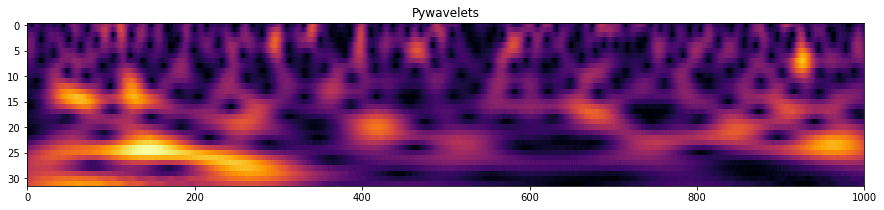

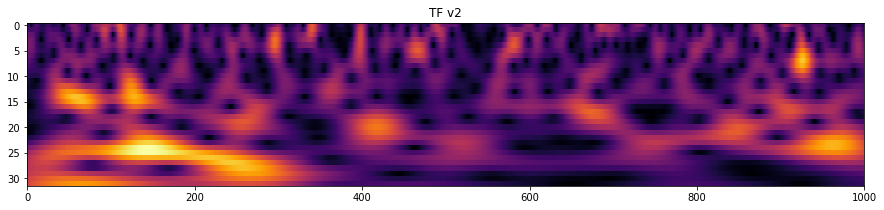

In [6]:
which_fb = 3

#single_spectrogram_np_v1 = spectrogram_np_v1[0,:,:,which_fb]
single_spectrogram_np_v2 = spectrogram_np_v2[0,:,:,which_fb]

plt.figure(figsize=(15, 3))
plt.title("Pywavelets")
plt.imshow(abs_coef * freqs[:, np.newaxis], interpolation='nearest', cmap=cm.inferno, aspect='auto')
plt.show()
#plt.figure(figsize=(15, 3))
#plt.title("TF v1")
#plt.imshow(single_spectrogram_np_v1, interpolation='none', cmap=cm.inferno, aspect='auto')
#plt.show()
plt.figure(figsize=(15, 3))
plt.title("TF v2")
plt.imshow(single_spectrogram_np_v2, interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

In [ ]:
# CWT v2
tf.reset_default_graph()

n_scalograms = fc_array.shape[0]

flattening = True

# Generate initial and last scale
s_0 = fs / upper_freq
s_n = fs / lower_freq

# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))

# Generate the wavelets
wavelets = []
frequencies = []
for j in range(n_scalograms):
    fc = fc_array[j]
    fb = fb_array[j]
    
    one_side = int(scales[-1] * np.sqrt(5 * fb))
    kernel_size = 2 * one_side + 1
    
    wavelet_bank_real = np.zeros((1, kernel_size, 1, n_scales))
    wavelet_bank_imag = np.zeros((1, kernel_size, 1, n_scales))
    freq = np.zeros(n_scales)
    for i in range(n_scales):
        scale = scales[i]
        freq[i] = fs / scale
        k_array = np.arange(kernel_size, dtype=np.float32) - one_side
        kernel_base = np.exp(-((k_array / scale) ** 2) / fb) / np.sqrt(np.pi * fb * scale)
        kernel_real = kernel_base * np.cos(2 * np.pi * fc * k_array / scale)
        kernel_imag = kernel_base * np.sin(2 * np.pi * fc * k_array / scale)
        if flattening:
            kernel_real = kernel_real * freq[i]
            kernel_imag = kernel_imag * freq[i]
        wavelet_bank_real[0, :, 0, i] = kernel_real
        wavelet_bank_imag[0, :, 0, i] = kernel_imag
    wavelets.append((wavelet_bank_real, wavelet_bank_imag))
    frequencies.append(freq)
    
# Show frequency bank
which_wavelet = 1

bank_real, bank_imag = wavelets[0]
kernel_real = bank_real[0, :, 0, which_wavelet]
kernel_imag = bank_imag[0, :, 0, which_wavelet]
plt.figure()
plt.plot(kernel_real)
plt.title("real")
plt.show()

plt.figure()
plt.plot(kernel_imag)
plt.title("imag")
plt.show()

print(wavelets[0][0].shape)

In [ ]:
inputs = np.array([segment])
border_crop=0
stride=1
name = "cwt"

# Generate the scalograms
border_crop = int(border_crop/stride)
start = border_crop
if border_crop == 0:
    end = None
else:
    end = -border_crop
with tf.variable_scope(name):
    # Reshape input
    inputs_expand = tf.expand_dims(inputs, axis=1)
    inputs_expand = tf.expand_dims(inputs_expand, axis=3)
    scalograms_list = []
    for j in range(n_scalograms):
        with tf.name_scope(name + "_" + str(j)):
            bank_real, bank_imag = wavelets[j] # each bank has shape kernel_size, 32
            # inputs_expand -> [batch, 1, time, 1]
            #kernels_real_v2 = np.reshape(bank_real, newshape=[1, -1, 1, n_scales])
            #kernels_imag_v2 = np.reshape(bank_imag, newshape=[1, -1, 1, n_scales])
            # print(kernels_real_v2.shape)
            # final kernel should have dimensions [height,width, in_chn, out_chn] -> [1,kernel_size,1,32]
            out_real = tf.nn.conv2d(input=inputs_expand, filter=bank_real,
                                   strides=[1,1,stride,1], padding="SAME")  # output should be [batch, 1, time, 32]
            out_imag = tf.nn.conv2d(input=inputs_expand, filter=bank_imag,
                                   strides=[1,1,stride,1], padding="SAME")  # output should be [batch, 1, time, 32]
            out_real_crop = out_real[:, :, start:end, :]
            out_imag_crop = out_imag[:, :, start:end, :]
            out_power = tf.sqrt(tf.square(out_real_crop) + tf.square(out_imag_crop))
            single_scalogram = tf.transpose(out_power, perm=[0, 3, 2, 1]) # output should be [batch, 32, time, 1]
            
            
            #single_scalogram_list = []
            #for i in range(n_scales):
            #    kernel_tuple = wavelets[j][i]
            #    kernel_real = kernel_tuple[0]
            #    kernel_imag = kernel_tuple[1]
            #    out_real = tf.nn.conv2d(input=inputs_expand, filter=kernel_real,
            #                            strides=[1, 1, stride, 1], padding="SAME")
            #    out_imag = tf.nn.conv2d(input=inputs_expand, filter=kernel_imag,
            #                            strides=[1, 1, stride, 1], padding="SAME")
                #out_real_crop = out_real[:, :, start:end, :]
                #out_imag_crop = out_imag[:, :, start:end, :]
            #    out_power = tf.sqrt(tf.square(out_real_crop) + tf.square(out_imag_crop))
            #    single_scalogram_list.append(out_power)
            #single_scalogram = tf.concat(single_scalogram_list, 1)
            scalograms_list.append(single_scalogram)
    scalograms = tf.concat(scalograms_list, -1)
    
    spectrogram = tf.squeeze(scalograms)
with tf.Session() as sess:
    spectrogram_np_v2 = sess.run(spectrogram)
    
print(spectrogram_np_v2.shape)

plt.figure(figsize=(15, 3))
plt.title("Pywavelets")
plt.imshow(abs_coef * freqs[:, np.newaxis], interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

plt.figure(figsize=(15, 3))
plt.title("TF v1")
plt.imshow(spectrogram_np_v1, interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()

plt.figure(figsize=(15, 3))
plt.title("TF v2")
plt.imshow(spectrogram_np_v2, interpolation='none', cmap=cm.inferno, aspect='auto')
plt.show()